# Eureka Robotics Take Home Test

## Name: Abhinav Thandanvittil Krishnankutty Jaju

This notebook layouts my thought process of how I proceeded to solve the given exercises and the steps I took. I have written out comments for each function/section to highlight its function. Thank you for giving me the opportunity to work on a very interesting problemset and giving me a chance with this take home test.

Note: The notebook might have to be re-run if a path cannot be generated from the random path planning. Apologies for this inconvenience due to a lack of time.

### Exercise 1: Solving a 2D motion planning problem by PRM

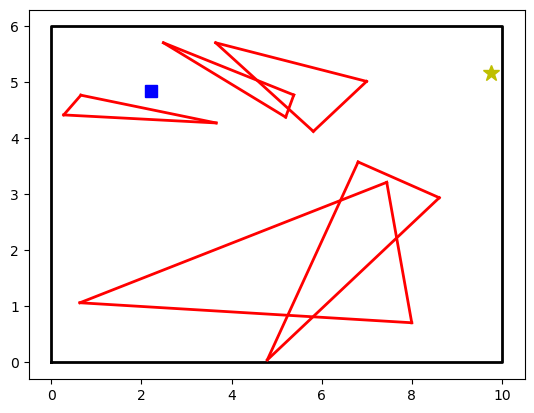

In [322]:
import numpy as np
import pylab as pl
import random
import sys

import environment_2d

# random_seed = random.randint(1, 5000)

# Sample code given by the github and exercise

pl.ion()
# Selected seed 781 after experimenting with a variety of seeds soley for testing and to ensure a fair env
np.random.seed(781)
env = environment_2d.Environment(10, 6, 5)
pl.clf()
env.plot()
q = env.random_query()
if q is not None:
  x_start, y_start, x_goal, y_goal = q
  env.plot_query(x_start, y_start, x_goal, y_goal)

# Initializing helper visualization functions used later to visualize the path planning and post processing
def plot():
    pl.plot([0, env.size_x, env.size_x, 0, 0], [0, 0, env.size_y, env.size_y, 0], "k", linewidth = 2)
    for ob in env.obs:
      ob.plot()

def plot_point(point):
    pl.plot(point[0], point[1], 'o')

def plot_query(x_start, y_start, x_goal, y_goal):
    pl.plot([x_start], [y_start], "bs", markersize = 8)
    pl.plot([x_goal], [y_goal], "y*", markersize = 12)

def plot_edge(edge):
    x = [edge[0][0], edge[1][0]]
    y = [edge[0][1], edge[1][1]]
    pl.plot(x, y, 'go-')
    
    coord = "({x:.1f}, {y:.1f})"
    
    pl.text(edge[0][0], edge[0][1], coord.format(x = edge[0][0], y = edge[0][1]))
    pl.text(edge[1][0], edge[1][1], coord.format(x = edge[1][0], y = edge[1][1]))

In [323]:
# The resolution at which it checks for collisions in every edge
# Also the resolution used during post-processing to select a random point along an edge
RESOLUTION = 0.01

# A wrapper function to simplify the function call
def checkCollision(x, y) -> bool:
    return env.check_collision(x, y)

# A helper class that is only used in the defined functions below
class Vertex:
    # X and Y coordinate of the vertex in the env
    x = 0
    y = 0

    def __init__(self, cur_x, cur_y) -> None:
        self.x = cur_x
        self.y = cur_y


# Function to find next point in an edge between two vertices. Used in checking collision
def getNextPointInEdge(vertex_a, slope, x, isX) -> float:
    if isX:
        return slope * (x - vertex_a.x) + vertex_a.y
    else:
        return (x - vertex_a.y)/slope + vertex_a.x

# Function to check whether an edge between two vertices will be collision free. True if it is collision free
def checkEdgeBetweenVertex(vertex_a, vertex_b) -> bool:
    direction = 1
    slope = float('inf')
    
    if (vertex_b.x - vertex_a.x) != 0:
        slope = (vertex_b.y - vertex_a.y)/(vertex_b.x - vertex_a.x)
        
    if 1 >= slope >= -1:
        if vertex_a.x > vertex_b.x:
            direction = -1
            
        for x in range(int(vertex_a.x/RESOLUTION), int(vertex_b.x/RESOLUTION + 1), direction):
            y = getNextPointInEdge(vertex_a, slope, x * RESOLUTION, True)
            
            if checkCollision(x * RESOLUTION, y):
                return False
    else:
        if vertex_a.y > vertex_b.y:
            direction = -1
        
        for y in range(int(vertex_a.y/RESOLUTION), int(vertex_b.y/RESOLUTION + 1), direction):
            x = getNextPointInEdge(vertex_a, slope, y * RESOLUTION, False)
            
            if checkCollision(x, y * RESOLUTION):
                return False

    return True

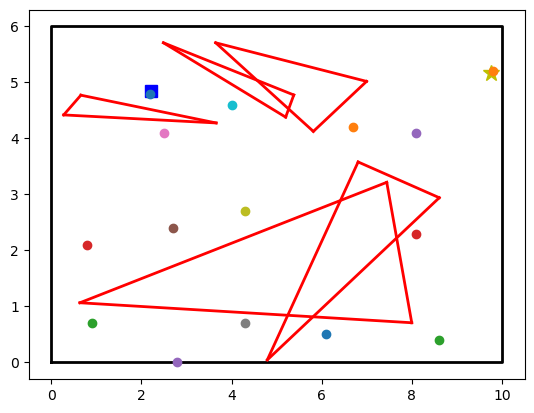

In [324]:
# Fun math and random imports
from math import floor
from math import sqrt
from random import randint


# The list of all vertices and edges to be created.
Vertices = []
Edges = []

# The X and Y scale limits of the env
MAX_X = 10
MAX_Y = 6

# Start and Goal information
x_start, y_start, x_goal, y_goal = q

# Adding the start and goal to the vertex list
Vertices.append([round(x_start, 1), round(y_start, 1)])
Vertices.append([round(x_goal, 1), round(y_goal, 1)])

# Iterating through each even coordinate and creating a random coordinate with a spread of +- 0.9
# This is to prevent blobs of vertices that may occur from a true random coordinate generator
for i in range(0, MAX_X, 2):
    for j in range(0, MAX_Y, 2):
        x = randint(i * 10, (i + 1) * 10 - 1)
        y = randint(j * 10, (j + 1) * 10 - 1)
        
        x = x/10
        y = y/10

        if Vertices.count([x,y]) != 0:
            continue

        if checkCollision(x, y):
            continue

        Vertices.append([x, y])
        
# Plotting the newly formed vertices 
plot()
plot_query(x_start, y_start, x_goal, y_goal)

for point in Vertices:
    plot_point(point)

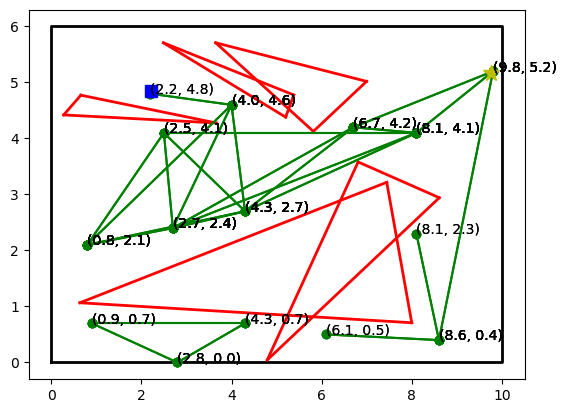

In [325]:
# Max distance within which it will allow edge formation between two vertices
MAX_DISTANCE = 6

# Returns the distance between two vertices
def getDistance(vertexa, vertexb) -> float:
    x1, y1 = vertexa
    x2, y2 = vertexb
    
    return sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    
# Edge formation between all vertices
for pointa in Vertices:
    for pointb in Vertices:
        if pointa == pointb:
            continue
        
        distance = getDistance(pointa, pointb)
        
        if distance > MAX_DISTANCE:
            continue
        
        vertexa = Vertex(pointa[0], pointa[1])
        vertexb = Vertex(pointb[0], pointb[1])
        
        if not checkEdgeBetweenVertex(vertexa, vertexb):
            continue

        if Edges.count([pointa, pointb]) != 0:
            continue
        
        Edges.append([pointa, pointb])

# Plotting the newly formed edges
plot()

for point in Vertices:
    plot_point(point)

for edge in Edges:
    plot_edge(edge)

plot_query(x_start, y_start, x_goal, y_goal)

## Pathfinding

In [326]:
# A serializing function to convert the coordinates as list to a string for use in a dictionary. format: [x,y]
def serializePoint(point) -> str:
    return str(point)

adjacency_dict = {}
vertex_dict = {}

# Creating an adjacency dictionary that shows each edge in the final graph with the distance between each vertex calculated.
# Format: vertex_a (key) : [vertex_b, distance] (value)
for edge in Edges:
    start = edge[0]
    end = edge[1]
    
    distance = round(getDistance(start, end), 2)
    
    key = serializePoint(start)
    
    if adjacency_dict.get(key) is None:
        adjacency_dict[key] = [[end, distance]]
    else:
        adjacency_dict[key].append([end, distance])

In [327]:
# The following functions allows us to verify if a path is possible between the start and goal by essentially flooding from the start till it finds the end
x_start, y_start, x_goal, y_goal = q
start = [round(x_start, 1), round(y_start, 1)]
end = [round(x_goal, 1), round(y_goal, 1)]

def find_path(start, end, path = []):
    
    path = path + [start]
    if start == end:
        return path
    
    key = serializePoint(start)
    
    if adjacency_dict.get(key) is None:
        return None
    
    for vertex in adjacency_dict.get(key):
        if vertex[0] not in path:
            new_path = find_path(vertex[0], end, path)
            if new_path:
                return new_path
    return None

final_path = find_path(start, end)

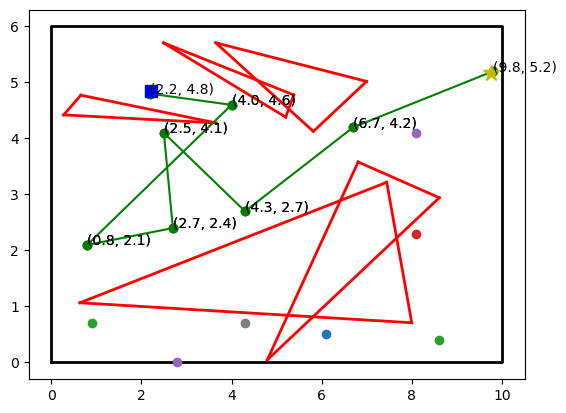

In [328]:
# Plotting one possible path which was found above
plot()

for point in Vertices:
    plot_point(point)

for i in range(len(final_path) - 1):
    edge = [final_path[i], final_path[i + 1]]
    plot_edge(edge)
    
plot_query(x_start, y_start, x_goal, y_goal)

## A STAR ALGORITHM

Implementation of the A* Algorithm to find an optimal path from the start to goal.

Heuristics:
- g -> distance between each vertex to the goal vertex
- h -> total distance covered
- f -> g + h

I also use the variable name "end" for the goal vertex to simplify my programming experience when typing

In [329]:
# The usual variables for A* implementation

# Format: [x, y] - coordinates
closed_list = []
# Format: [f, [x, y]] - f heuristic and coordinates
open_list = []
# Format: vertexa (key) : vertexb (value)
parent = {}
distance = 0

# Defining the start and goal vertex
x_start, y_start, x_goal, y_goal = q
start = [round(x_start, 1), round(y_start, 1)]
end = [round(x_goal, 1), round(y_goal, 1)]

open_list.append([0, start])

# A helper function to help find whether a vertex is in the open list
def find_in_open(vertex):
    for i in range(len(open_list)):
        if open_list[i][1] == vertex:
            return i
    return -1

# A* Algorithm
while (len(open_list) != 0):
    pop_vertex = open_list.pop(0)[1]
    closed_list.append(pop_vertex)
    
    if pop_vertex == end:
        # Adding the goal vertex to the final vertex in the path
        parent[str(closed_list[len(closed_list) - 2])] = end
        break
    
    key = serializePoint(pop_vertex)
    
    for edge in adjacency_dict.get(key):
        if edge[0] in closed_list:
            continue
        
        f = distance + edge[1] + getDistance(edge[0], end)
        g = distance + edge[1]
        
        if find_in_open(edge[0]) == -1:
            open_list.append([f, edge[0]])
            parent[str(pop_vertex)] = edge[0]
            open_list.sort()
        else:
            i = find_in_open(edge[0])
            if f < open_list[i][0]:
                open_list[i] = [f, edge[0]]
                parent[str(pop_vertex)] = edge[0]
                open_list.sort()
                
# Constructing the path using the parent dictionary
cur_edge = start
path = [start]

while (cur_edge != end):
    key = str(cur_edge)
    if parent.get(key) is None:
        continue
    cur_edge = parent[key]
    path.append(cur_edge)

print(path)

[[2.2, 4.8], [4.0, 4.6], [4.3, 2.7], [8.1, 4.1], [9.8, 5.2]]


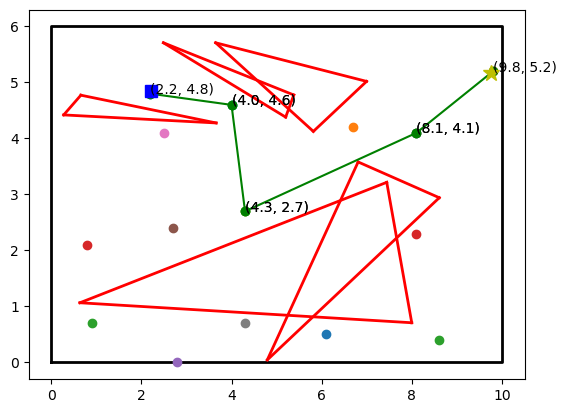

In [330]:
# Plotting out the optimized path found by the A* algorithm
plot()

for point in Vertices:
    plot_point(point)

for i in range(len(path) - 1):
    edge = [path[i], path[i + 1]]
    plot_edge(edge)
    
plot_query(x_start, y_start, x_goal, y_goal)

### Excercise 2: Post-processing a 2D path

In [331]:
# Defining the new path list which will consist of the new post processed path
newpath = [path[0]]

# Function to help choose a random point from the edge between two given vertices
def chooseRandomPoint(vertexa, vertexb):
    x1, y1 = vertexa.x, vertexa.y
    x2, y2 = vertexb.x, vertexb.y
    
    random_x = 0
    random_y = 0
    
    slope = float('inf')
    
    if (x2 - x1) != 0:
        slope = (y2 - y1)/(x2 - x1)
        
    
    if 1 >= slope >= -1:
        if x1 <= x2:
            random_x = randint(int(x1/RESOLUTION), int(x2/RESOLUTION)) * RESOLUTION
            random_y = getNextPointInEdge(vertexa, slope, random_x, True)
        else:
            random_x = randint(int(x2/RESOLUTION), int(x1/RESOLUTION)) * RESOLUTION
            random_y = getNextPointInEdge(vertexa, slope, random_x, True)
    else:
        if y1 <= y2:
            random_y = randint(int(y1/RESOLUTION), int(y2/RESOLUTION)) * RESOLUTION
            random_x = getNextPointInEdge(vertexa, slope, random_y, False)
        else:
            random_y = randint(int(y2/RESOLUTION), int(y1/RESOLUTION)) * RESOLUTION
            random_x = getNextPointInEdge(vertexa, slope, random_y, False)
    
    return [round(random_x, 1), round(random_y, 1)]

# Storing the previous start vertex in case it changes after one iteration of post processing
prev_new_vertex = [path[0][0], path[0][1]]

i = 0
while (i < len(path) - 2):
    # Using the new start vertex to prevent overlapping paths
    vertex1 = Vertex(prev_new_vertex[0], prev_new_vertex[1])
    vertex2 = Vertex(path[i + 1][0], path[i + 1][1])
    vertex3 = Vertex(path[i + 2][0], path[i + 2][1])
    
    t1 = chooseRandomPoint(vertex2, vertex1)
    t2 = chooseRandomPoint(vertex2, vertex3)
    
    vertex_t1 = Vertex(t1[0], t1[1])
    vertex_t2 = Vertex(t2[0], t2[1])
    
    # Checking whether the new path between the two random points is collision free
    if checkEdgeBetweenVertex(vertex_t1, vertex_t2):
        newpath.append(t1)
        newpath.append(t2)
        prev_new_vertex = t2
    else:
        newpath.append([path[i + 1][0], path[i + 1][1]])
        prev_new_vertex = [path[i + 1][0], path[i + 1][1]]
    
    i += 1

# Adding the goal vertex to the new path
newpath.append(path[len(path) - 1])    

print(newpath)

[[2.2, 4.8], [4.0, 4.6], [4.2, 3.3], [6.7, 3.6], [7.4, 3.9], [8.5, 4.4], [9.8, 5.2]]


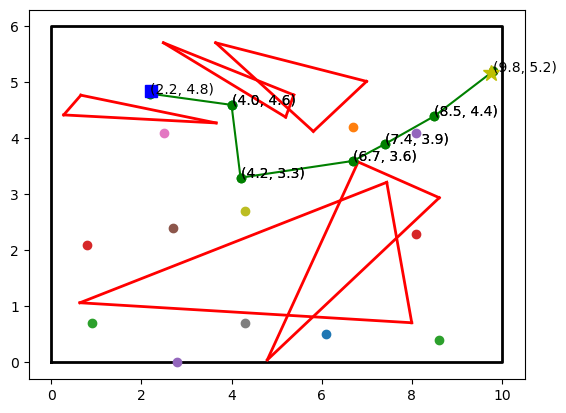

In [332]:
# Plotting the new post process path
plot()

for point in Vertices:
    plot_point(point)

for i in range(len(newpath) - 1):
    edge = [newpath[i], newpath[i + 1]]
    plot_edge(edge)
    
plot_query(x_start, y_start, x_goal, y_goal)